In [7]:
import sys
from pathlib import Path
import json

import numpy as np
import pennylane as qml
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.providers.aer import StatevectorSimulator
from qiskit.circuit.library import ZZFeatureMap
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.tensorboard import SummaryWriter
from pandas import DataFrame

sys.path.extend(['/home/quic/QUIC-Projects/'])
from classifiers.quantum.qml.qasvm import PseudoTensorSoftQASVM
from classifiers.datasets.sklearn import SklearnDataset
from classifiers.quantum.ansatz import MultilayerCircuit9FeatureMap
from classifiers.convex.svm import CvxSoftQASVM

In [8]:
# simulation setting
dir_name = 'QAA_simulation_1'
n_params_per_layer = 1

In [9]:
# setting
from pandas import read_csv
dir_path = Path.cwd() / dir_name
epsilon_summary = read_csv(dir_path/'epsilon_summary')
delta_summary = read_csv(dir_path/'delta_summary')
accuracy_summary = read_csv(dir_path/'accuracy_summary')
reference_accuracy_summary = read_csv(dir_path/'reference_accuracy_summary')
reference_cost_summary = read_csv(dir_path/'reference_cost_summary')

n_layers_list = np.array(epsilon_summary[epsilon_summary.columns[0]])
n_qubits_list = np.array(epsilon_summary.columns[1:]).astype(int)

epsilon_summary = epsilon_summary[epsilon_summary.columns[1:]]
delta_summary = delta_summary[delta_summary.columns[1:]]
accuracy_summary = accuracy_summary[accuracy_summary.columns[1:]]
reference_accuracy_summary = reference_accuracy_summary[reference_accuracy_summary.columns[1:]]
reference_cost_summary = reference_cost_summary[reference_cost_summary.columns[1:]]

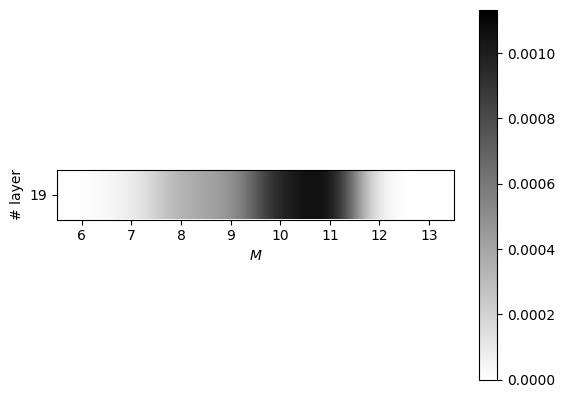

In [10]:
fig, ax = plt.subplots()
mappable = ax.imshow(epsilon_summary, cmap='binary', interpolation='gaussian')
ax.set_xlabel(r'$M$')
ax.set_ylabel('# layer')
ax.set_xticks(np.arange(len(n_qubits_list)))
ax.set_yticks(np.arange(len(n_layers_list)))
ax.set_xticklabels(n_qubits_list)
ax.set_yticklabels(n_layers_list)
fig.colorbar(mappable)

In [11]:
N_qubits, N_layers = np.meshgrid(n_qubits_list, n_layers_list)
N_qubits, N_layers

(array([[ 6,  7,  8,  9, 10, 11, 12, 13]]),
 array([[19, 19, 19, 19, 19, 19, 19, 19]]))

In [12]:
N_params = n_params_per_layer*N_qubits*N_layers
# N_params = N_layers
N_params

array([[114, 133, 152, 171, 190, 209, 228, 247]])

In [13]:
epsilon_summary.to_numpy()

array([[2.81373836e-06, 6.87375270e-05, 3.50452485e-04, 4.44180103e-04,
        9.97457835e-04, 1.13209796e-03, 0.00000000e+00, 0.00000000e+00]])

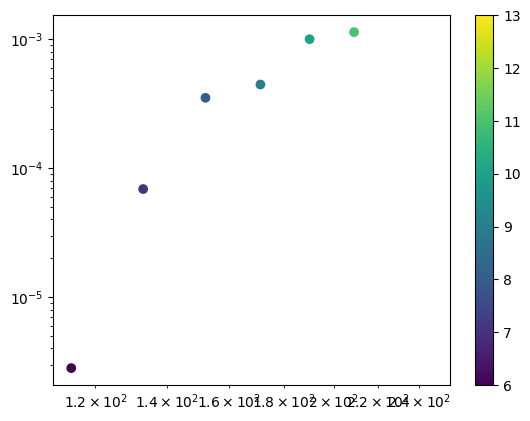

In [14]:
plt.scatter(N_params.flatten(), epsilon_summary.to_numpy().flatten(), c=N_qubits.flatten())
plt.colorbar()
plt.xscale('log')
plt.yscale('log')

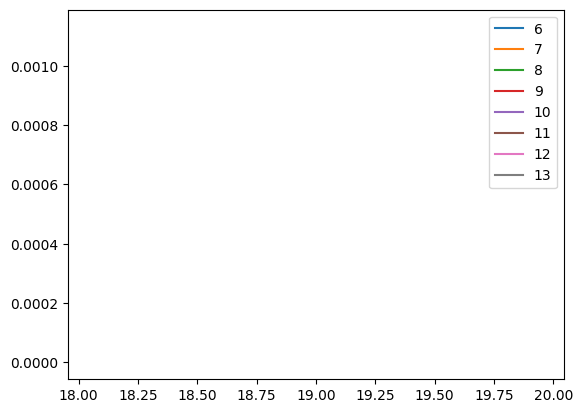

In [15]:
for i, m in enumerate(n_qubits_list):
    plt.plot(N_layers[:, i], epsilon_summary.to_numpy()[:, i], label=m)
plt.legend()

In [16]:
epsilon_summary

,6,7,8,9,10,11,12,13
0,0.000003,0.000069,0.00035,0.000444,0.000997,0.001132,0.0,0.0


0.9384426861098776


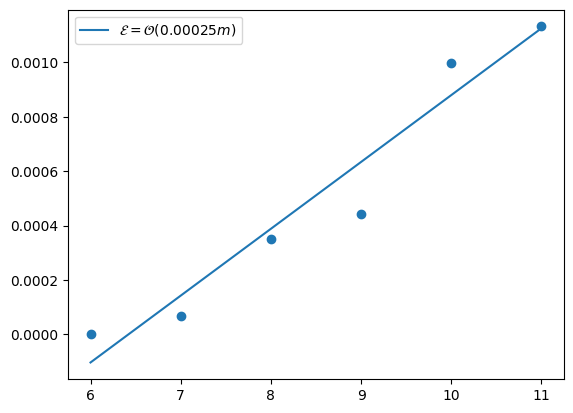

In [19]:
from sklearn.linear_model import HuberRegressor

# x = np.concatenate([n_qubits_list.reshape(-1, 1), n_qubits_list.reshape(-1, 1)])
# y = np.concatenate([epsilon_summary.iloc[-1].to_numpy(), epsilon_summary.iloc[-2].to_numpy()], axis=0)
x = n_qubits_list.reshape(-1, 1)[:-2]
y = epsilon_summary.iloc[-1].to_numpy()[:-2]

huber = HuberRegressor().fit(x, y)
print(huber.score(x, y))
plt.scatter(x, y)
plt.plot(x, huber.predict(x), label=r'$\mathcal{{E}} = \mathcal{{O}}({{{:.5f}}}m)$'.format(huber.coef_[0]))
plt.legend()

/home/quic/anaconda/envs/qiskit/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/quic/anaconda/envs/qiskit/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/quic/anaconda/envs/qiskit/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/quic/anaconda/envs/qiskit/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/quic/anaconda/envs/qiskit/lib/python3.9/site-packages/scipy/optimize/_minpack_

nan
nan
nan
nan
nan
nan
nan
nan


/home/quic/anaconda/envs/qiskit/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/quic/anaconda/envs/qiskit/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/quic/anaconda/envs/qiskit/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/quic/anaconda/envs/qiskit/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/quic/anaconda/envs/qiskit/lib/python3.9/site-packages/scipy/optimize/_minpack_

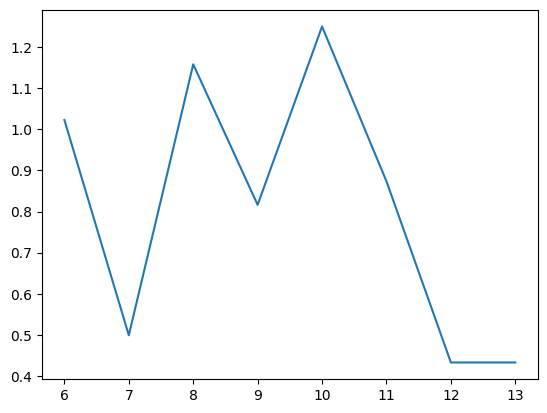

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit

def f(x, A, gamma, B, C):
    return A*np.exp(-x/gamma)+B*x+C

gamma_list = []
for i, m in enumerate(n_qubits_list):
    X, Y = N_layers[:, i], epsilon_summary.to_numpy()[:, i]
    popt, pcov = curve_fit(f, X, Y, maxfev=10000, bounds=(0, np.inf))
    gamma_list.append(popt[1])
    print(r2_score(Y, f(X, *popt)))

plt.plot(n_qubits_list, gamma_list)


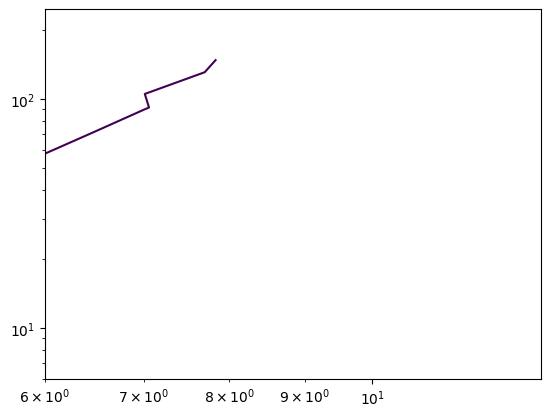

In [11]:
level = 5*np.min(epsilon_summary.to_numpy()[1:, 1:], axis=None)
c = plt.contour(N_qubits, N_params, epsilon_summary, levels=[level])
plt.xscale('log')
plt.yscale('log')

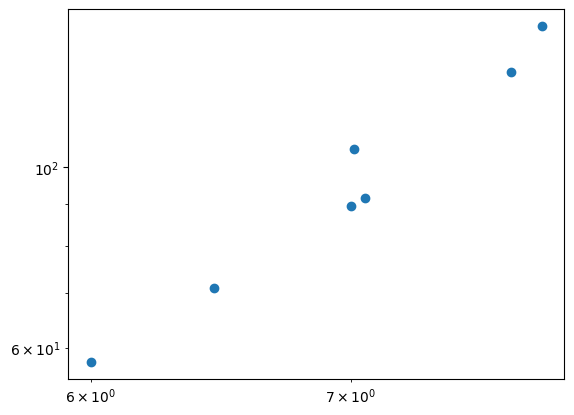

In [12]:
v = c.collections[0].get_paths()[0].vertices

plt.scatter(v[:, 0], v[:, 1])
plt.xscale('log')
plt.yscale('log')

In [13]:
from sklearn.linear_model import LinearRegression
X = N_qubits
Y = np.log2(N_layers*n_params_per_layer*N_qubits)
Z = np.log2(epsilon_summary.to_numpy())
XY = np.asarray(list(zip(X.flatten(), Y.flatten())))
ZZ = Z.flatten()
reg = LinearRegression().fit(XY, ZZ, sample_weight=(X.flatten()+Y.flatten()))
print("epsilon = O(2^{:.3f} * M^{:.3f} * (# params)^{:.3f}), R^2={:.3f}".format(reg.intercept_, reg.coef_[0], reg.coef_[1], reg.score(XY, ZZ)))

epsilon = O(2^-10.344 * M^0.686 * (# params)^-0.860), R^2=0.626


In [14]:
lv = np.log2(v)
weight = (2**lv[:, 0])
reg_ = LinearRegression().fit(lv[:, 0].reshape(-1, 1), lv[:, 1], sample_weight=weight)
print("# params = O(2^{:.3f} * log(M)^{:.3f}), R^2={:.3f}".format(reg_.intercept_, reg_.coef_[0], reg_.score(lv[:, 0].reshape(-1, 1), lv[:, 1])))

# params = O(2^-3.254 * log(M)^3.503), R^2=0.968


In [15]:
reg__ = LinearRegression().fit(2**lv[:, 0].reshape(-1, 1), lv[:, 1], sample_weight=weight)
print("# params = O(2^{:.3f} * M^{:.3f}), R^2={:.3f}".format(reg__.intercept_, reg__.coef_[0], reg__.score(2**lv[:, 0].reshape(-1, 1), lv[:, 1])))

# params = O(2^1.449 * M^0.730), R^2=0.972


Text(0.5, 1.0, '# params = $\\mathcal{O}(2^{-3.254} \\times log(M)^{3.503})$, $R^2=0.968$')

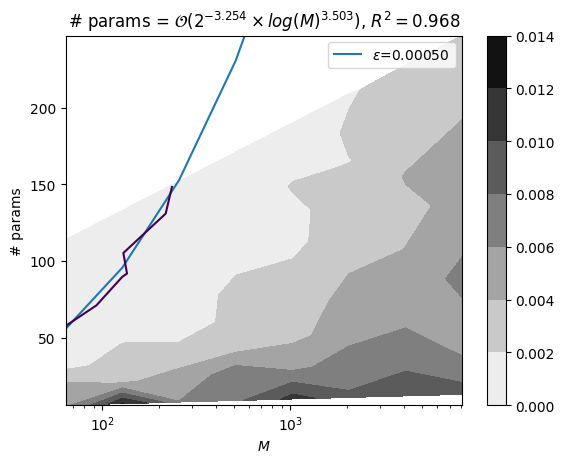

In [16]:
plt.contourf(2**N_qubits, N_params, epsilon_summary, cmap='binary')
plt.plot((2**N_qubits)[0], (2**reg_.intercept_*N_qubits**reg_.coef_[0])[0], label=r'$\epsilon$={:.5f}'.format(level))
plt.colorbar()
c = plt.contour(2**N_qubits, N_params, epsilon_summary, levels=[level])
plt.ylabel('# params')
plt.ylim([None, np.max(N_params)])
plt.xlabel(r'$M$')
plt.xscale('log')
plt.legend()
plt.title(r"# params = $\mathcal{{O}}(2^{{{:.3f}}} \times log(M)^{{{:.3f}}})$, $R^2={:.3f}$".format(reg_.intercept_, reg_.coef_[0], reg_.score(lv[:, 0].reshape(-1, 1), lv[:, 1])))

Text(0.5, 1.0, '# params = $\\mathcal{O}(2^{-3.254} \\times log(M)^{3.503})$, $R^2=0.968$')

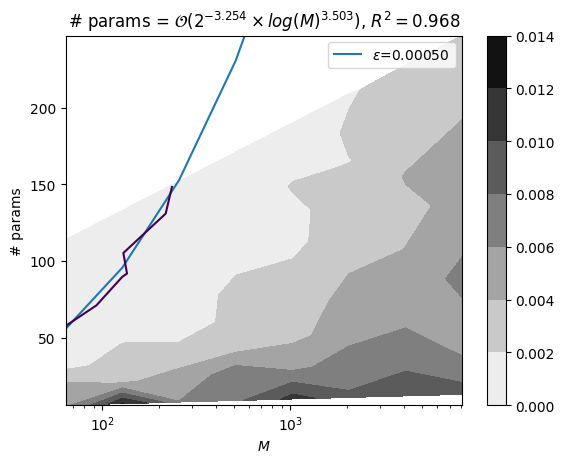

In [ ]:
plt.contourf(2**N_qubits, N_params, epsilon_summary, cmap='binary')
plt.plot((2**N_qubits)[0], (2**reg_.intercept_*N_qubits**reg_.coef_[0])[0], label=r'$\epsilon$={:.5f}'.format(level))
plt.colorbar()
c = plt.contour(2**N_qubits, N_params, epsilon_summary, levels=[level])
plt.ylabel('# params')
plt.ylim([None, np.max(N_params)])
plt.xlabel(r'$M$')
plt.xscale('log')
plt.legend()
plt.title(r"# params = $\mathcal{{O}}(2^{{{:.3f}}} \times log(M)^{{{:.3f}}})$, $R^2={:.3f}$".format(reg_.intercept_, reg_.coef_[0], reg_.score(lv[:, 0].reshape(-1, 1), lv[:, 1])))

Text(0.5, 1.0, '# params = $\\mathcal{O}(2^{1.449} \\times M^{0.730})$, $R^2=0.972$')

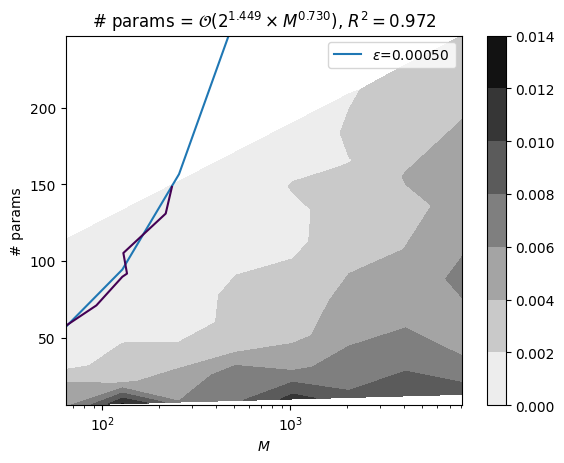

In [17]:
plt.contourf(2**N_qubits, N_params, epsilon_summary, cmap='binary')
plt.plot((2**N_qubits)[0], (2**reg__.intercept_*(2**N_qubits)**reg__.coef_[0])[0], label=r'$\epsilon$={:.5f}'.format(level))
plt.colorbar()
c = plt.contour(2**N_qubits, N_params, epsilon_summary, levels=[level])
plt.ylabel('# params')
plt.ylim([None, np.max(N_params)])
plt.xlabel(r'$M$')
plt.xscale('log')
plt.legend()
plt.title(r"# params = $\mathcal{{O}}(2^{{{:.3f}}} \times M^{{{:.3f}}})$, $R^2={:.3f}$".format(reg__.intercept_, reg__.coef_[0], reg__.score(2**lv[:, 0].reshape(-1, 1), lv[:, 1])))

In [68]:
weight = (2**lv[:, 0]).reshape(-1, 1)

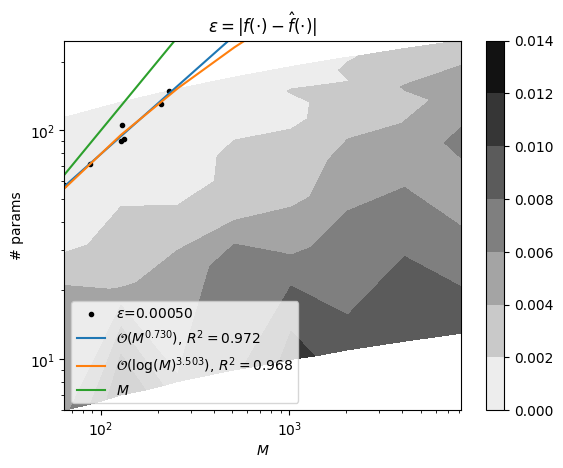

In [18]:
cmapable = plt.contourf(2**N_qubits, N_params, epsilon_summary, cmap='binary')
plt.scatter(2**v[:, 0], v[:, 1], label = r'$\epsilon$={:.5f}'.format(level), marker='.', color='k')
plt.plot((2**N_qubits)[0], (2**reg__.intercept_*(2**N_qubits)**reg__.coef_[0])[0], label=r"$\mathcal{{O}}(M^{{{:.3f}}})$, $R^2={:.3f}$".format(reg__.coef_[0], reg__.score(2**lv[:, 0].reshape(-1, 1), lv[:, 1])))
plt.plot((2**N_qubits)[0], (2**reg_.intercept_*N_qubits**reg_.coef_[0])[0], label=r"$\mathcal{{O}}(\log(M)^{{{:.3f}}})$, $R^2={:.3f}$".format(reg_.coef_[0], reg_.score(lv[:, 0].reshape(-1, 1), lv[:, 1])))
plt.plot((2**N_qubits)[0], (2**N_qubits)[0], label=r'$M$')
plt.colorbar(cmapable)
plt.ylabel('# params')
plt.ylim([None, np.max(N_params)])
plt.xlabel(r'$M$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title(r"$\epsilon=\left|f(\cdot)-\hat{f}(\cdot)\right|$")
plt.savefig(dir_path / 'readme_figure.png', dpi=300)

plt.savefig(dir_path / 'readme_figure.pdf', dpi=300)

0.9734176460807057
[0.03503532] 0.33762340716305855


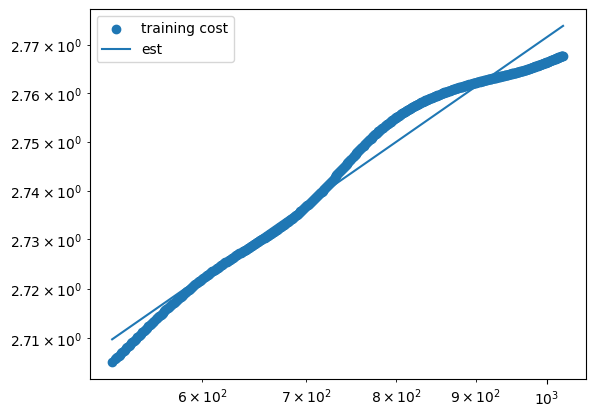

In [45]:
import seaborn as sns
from sklearn.linear_model import LinearRegression
training_cost = float(reference_cost_summary.iloc[-1, -1])
steps = train_df['Step'].values
delta = train_df['Value'].values - training_cost
steps = steps[512:]
delta = delta[512:]
plt.scatter(steps, -np.log10(delta), label='training cost')

x = np.log10(steps.reshape(-1, 1)) # T
y = np.log10(-np.log10(delta)) # log(1/d)

huber = LinearRegression().fit(x, y)
print(huber.score(x, y))
plt.plot(10**x, 10**huber.predict(x), label='est')
plt.legend()
plt.xscale('log')
plt.yscale('log')

print(huber.coef_, huber.intercept_)


In [20]:
reference_cost_summary.iloc[-1, -1]

0.000860749349229